In [1]:
import json 
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import combinations
from dgl import load_graphs
import sys
import os
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.manifold import TSNE
import networkx as nx
sys.path.insert(1, '..')
from dgl_graphsage.utils import load_graph
from dgl_graphsage.utils import load_features

Using backend: pytorch


# Load Needed

In [2]:
with open('batch_recommendations.json') as woahs:
     woah = json.load(woahs)

In [3]:
%%time
# Loading Graph ~ 3min
feat_dir = "../../data/a13group1/features/merged_features.csv"
double_edge_dir = "../../data/a13group1/double_edges_170k.bin"
feat_data, uri_map = load_features(feat_dir)
dgl_G = nx.read_gpickle("../../data/a13group1/graph_170k.gpickle")
dgl_G, weights = load_graph(dgl_G, uri_map)

CPU times: user 2min 7s, sys: 29.5 s, total: 2min 36s
Wall time: 2min 28s


# Song Connectivity Within Recommendation

In [4]:
%%time
in_rec_accs = []
for i in range(len(woah)):
    res = list(combinations(woah[i]['recs'], 2))

    checks = []
    for pair in res:
        check = uri_map[pair[0]] in dgl_G.out_edges(uri_map[pair[1]])[1]
        checks.append(check)
        
    in_rec_accs.append(np.count_nonzero(checks) / len(checks))

CPU times: user 3min 2s, sys: 27.7 s, total: 3min 30s
Wall time: 3min 4s


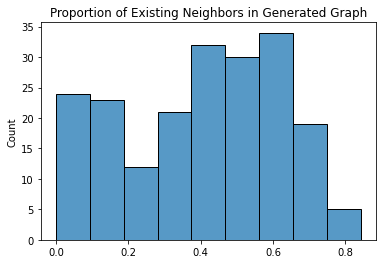

In [5]:
sns.histplot(in_rec_accs).set(title=f'Proportion of Existing Neighbors in Generated Graph')
plt.savefig('rec_connectivity.jpg')

# Feature Distribution

In [6]:
std_scaler = StandardScaler()
one_hot = OneHotEncoder()

edafeats = pd.read_csv(os.path.join(os.path.expanduser('~'), 'GNN-Spotify-Recommender-Project/data/a13group1/songset_features_170k'))
edafeats = edafeats.drop(columns=['Unnamed: 0', 'type', 'track_href', 'analysis_url'])

edafeats['loudness'] = std_scaler.fit_transform(edafeats[['loudness']])
edafeats['tempo'] = std_scaler.fit_transform(edafeats[['tempo']])
edafeats['duration_ms'] = std_scaler.fit_transform(edafeats[['duration_ms']])

In [7]:
edafeats.drop(columns=['id', 'uri'])

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,0.904,0.813,4,0.241283,0,0.1210,0.031100,0.006970,0.0471,0.810,0.147007,-0.117592,4
1,0.774,0.838,5,0.932608,0,0.1140,0.024900,0.025000,0.2420,0.924,0.745093,-0.396133,4
2,0.664,0.758,2,0.354373,0,0.2100,0.002380,0.000000,0.0598,0.701,-0.744457,-0.027580,4
3,0.892,0.714,4,0.468764,0,0.1410,0.201000,0.000234,0.0521,0.817,-0.686176,0.283416,4
4,0.853,0.606,0,0.784854,1,0.0713,0.056100,0.000000,0.3130,0.654,-0.897559,-0.110287,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
170084,0.551,0.822,11,0.260131,0,0.0614,0.001540,0.000000,0.2150,0.360,0.200831,0.261303,4
170085,0.480,0.761,6,0.777921,1,0.0367,0.120000,0.000000,0.2960,0.359,1.322800,1.290823,4
170086,0.402,0.767,11,0.325126,0,0.1710,0.000077,0.000003,0.3930,0.558,1.944497,-0.590001,4
170087,0.678,0.826,0,0.753223,0,0.0591,0.005240,0.000000,0.0951,0.706,0.641290,0.036080,4


In [8]:
def get_distribution(edafeats, uri_recs):
    numerical = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms',]
    categorical = ['key', 'mode', 'time_signature']

    feat_vars = {'danceability': [], 'energy': [], 'loudness': [], 'speechiness': [], 'acousticness': [], 'instrumentalness': [], 'liveness': [], 'valence': [], 'tempo': [], 'duration_ms': [],'key': [], 'mode': [], 'time_signature': []}
    feat_avgs = {'danceability': [], 'energy': [], 'loudness': [], 'speechiness': [], 'acousticness': [], 'instrumentalness': [], 'liveness': [], 'valence': [], 'tempo': [], 'duration_ms': [],'key': [], 'mode': [], 'time_signature': []}
    feat_difs = {'danceability': [], 'energy': [], 'loudness': [], 'speechiness': [], 'acousticness': [], 'instrumentalness': [], 'liveness': [], 'valence': [], 'tempo': [], 'duration_ms': [],'key': [], 'mode': [], 'time_signature': []}
    feat_ranges = {'danceability': [], 'energy': [], 'loudness': [], 'speechiness': [], 'acousticness': [], 'instrumentalness': [], 'liveness': [], 'valence': [], 'tempo': [], 'duration_ms': [],'key': [], 'mode': [], 'time_signature': []}

    for i in numerical:
        cur_feats = edafeats[edafeats['id'].isin(uri_recs)]

        var = np.var(cur_feats[i])
        feat_vars[i] = (var)

        avg = np.mean(cur_feats[i])
        feat_avgs[i] = (avg)

        difs = np.mean(np.abs(cur_feats[i].diff())[1:])
        feat_difs[i] = difs

        ranges = np.abs(np.max(cur_feats[i]) - np.min(cur_feats[i]))
        feat_ranges[i] = ranges

    for i in categorical:
        highest = max(cur_feats[i].value_counts() / cur_feats[i].count())
        feat_vars[i] = highest

    feat_avgs.pop('key')
    feat_avgs.pop('mode')
    feat_avgs.pop('time_signature')

    feat_difs.pop('key')
    feat_difs.pop('mode')
    feat_difs.pop('time_signature')

    feat_ranges.pop('key')
    feat_ranges.pop('mode')
    feat_ranges.pop('time_signature')
    
    return feat_vars, feat_avgs, feat_difs, feat_ranges

In [9]:
%%time
# Get original playlists and recommendations for them.
# Saving sample of playlists
original_playlists = []
generated_playlists = []
for i in range(len(woah)):
    saved_seeds = woah[i]['seeds']
    saved_recs = woah[i]['recs']
    
    original_playlists.append(saved_seeds)
    generated_playlists.append(saved_recs)

CPU times: user 192 µs, sys: 0 ns, total: 192 µs
Wall time: 217 µs


In [10]:
%%time
# Will get the variances from originals and generated.
# Saves the differences between the variances for each playlist/generated playlist
size = len(original_playlists)
differences = {'danceability': [], 'energy': [], 'loudness': [], 'speechiness': [], 'acousticness': [], 'instrumentalness': [], 'liveness': [], 'valence': [], 'tempo': [], 'duration_ms': [],'key': [], 'mode': [], 'time_signature': []}
for i in range(size):
    feat_vars_og, feat_avgs_og, feat_difs_og, feat_ranges_og = get_distribution(edafeats, original_playlists[i])
    feat_vars_gen, feat_avgs_gen, feat_difs_gen, feat_ranges_gen = get_distribution(edafeats, generated_playlists[i])
    
    for each in differences.keys():
        differences[each].append(np.abs(feat_vars_og[each] - feat_vars_gen[each]))

CPU times: user 36.1 s, sys: 89.3 ms, total: 36.2 s
Wall time: 36.2 s


In [11]:
# Gets the average difference in variance for each feature
avg_differences = {'danceability': [], 'energy': [], 'loudness': [], 'speechiness': [], 'acousticness': [], 'instrumentalness': [], 'liveness': [], 'valence': [], 'tempo': [], 'duration_ms': [],'key': [], 'mode': [], 'time_signature': []}
for i in avg_differences.keys():
    avg_differences[i] = np.mean(np.array(differences[i]))

In [12]:
avg_differences

{'danceability': 0.008089644615046054,
 'energy': 0.010356481690654002,
 'loudness': 0.17758967247715737,
 'speechiness': 0.004830276776209566,
 'acousticness': 0.02258829699550483,
 'instrumentalness': 0.013714854720833072,
 'liveness': 0.011005802919250907,
 'valence': 0.013136804163277347,
 'tempo': 0.2734098245952523,
 'duration_ms': 0.23354178660096106,
 'key': 0.07584029283258614,
 'mode': 0.09781440358991571,
 'time_signature': 0.05433704884472507}

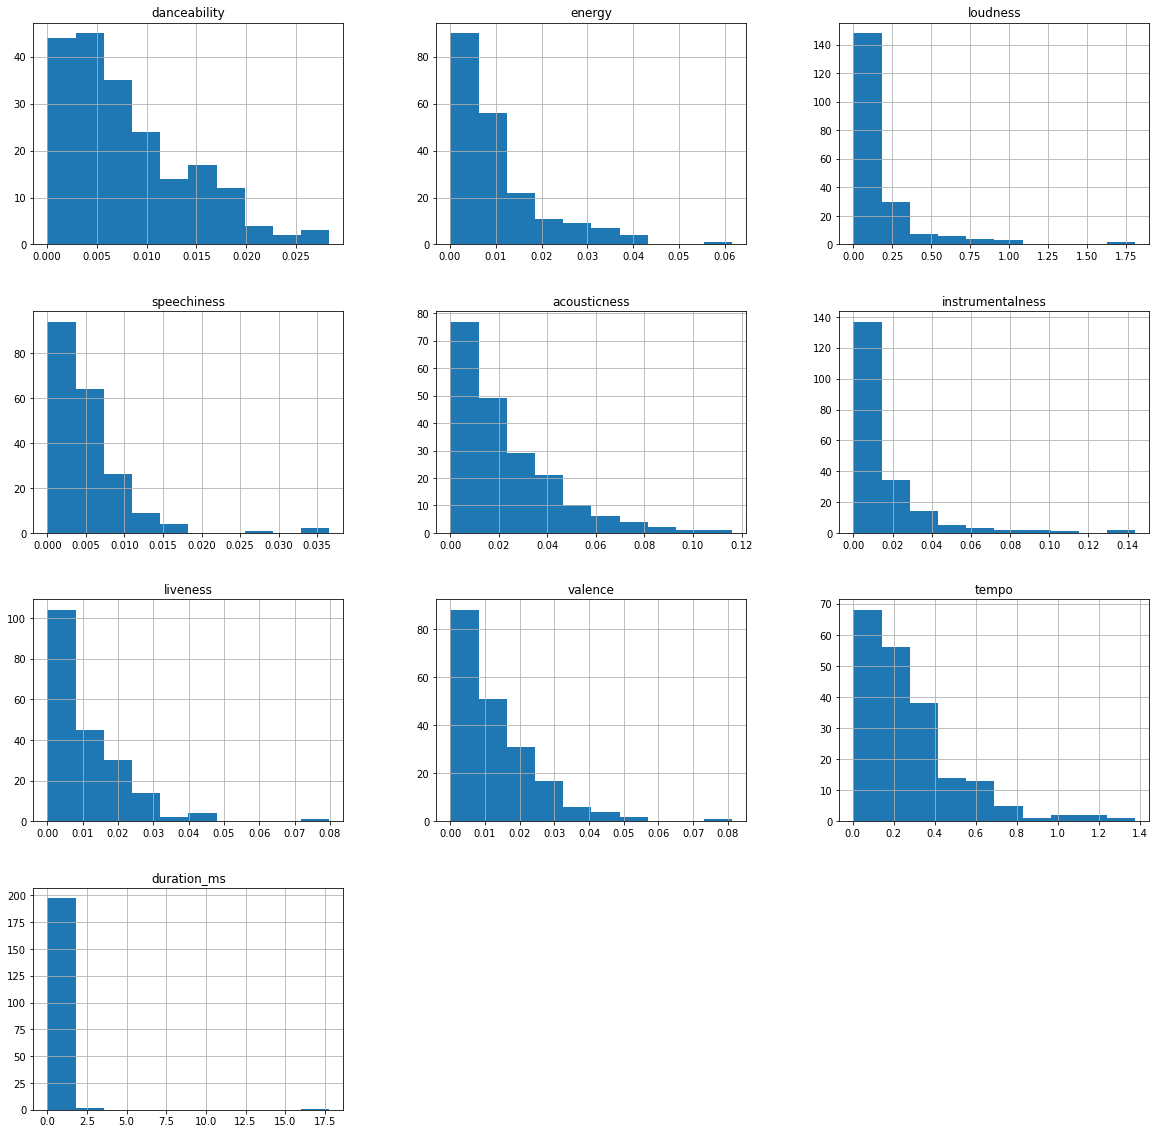

In [13]:
# Plots the differences for each feature
pd.DataFrame(differences)[['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms']].hist(figsize=(20,20))
plt.savefig('var_differences.jpg')

# Embedding T-SNE
Will require training of the model

In [ ]:
# %%time
# # Loading Graph ~ 3min
# feat_dir = "../../data/a13group1/features/merged_features.csv"
# double_edge_dir = "../../data/a13group1/double_edges_170k.bin"
# feat_data, adj_list, dgl_G, uri_map = r.load_double_edge(feat_dir, double_edge_dir)

In [ ]:
# %%time
# # Training the Model. GPU ~ 00:00:40
# with open('../../config/model-params.json') as fh:
#             model_cfg = json.load(fh)
# model, pred = train(dgl_G, feat_data, adj_list, **model_cfg)

# # Put everything on CPU
# model = model.to('cpu')
# pred = pred.to('cpu')

In [ ]:
# # Create Embeddings
# z = model(dgl_G, feat_data)

# # Create Predictions
# # In the form of the strength of the connection between source, destination from dgl_G.edges()
# preds = pred(dgl_G, z)

### T-SNE

In [ ]:
# # Instantialte tsne, specify cosine metric
# tsne = TSNE(n_iter = 1000, metric = 'cosine', square_distances=True)

In [ ]:
# %%time
# ## WARNING -- AROUND 30 MINUTES TO COMPLETE
# embeddings2d = tsne.fit_transform(z.detach().numpy())

In [ ]:
# # Create DF
# embeddingsdf = pd.DataFrame()
# # Add game names
# embeddingsdf['id'] = edafeats['id']
# # Add x coordinate
# embeddingsdf['x'] = embeddings2d[:,0]
# # Add y coordinate
# embeddingsdf['y'] = embeddings2d[:,1]
# # Check
# embeddingsdf.head()


In [ ]:
# # Set figsize
# fig, ax = plt.subplots(figsize=(10,8))
# # Scatter points, set alpha low to make points translucent
# ax.scatter(embeddingsdf.x, embeddingsdf.y, alpha=.01)
# plt.title('Scatter plot of Song Embeddings T-SNE')
# plt.savefig('embedding_tsne.jpg')
# plt.show()